In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

C:\Users\remil\.conda\envs\lcpfn\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import lcpfn 
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import torch
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
# curve data is 100 points
# split data into 50 and 50
# given first 50 points predict next 50 points
input_length = 15  # Num input elements
target_length = 100  # Num target elements

# get data (100 curves)
# Y seems to be the true curve data, X is just indecies???
get_batch_func = lcpfn.create_get_batch_func(prior=lcpfn.sample_from_prior)
X, Y, Y_noisy = get_batch_func(batch_size=100, seq_len=100, num_features=1)
Y = Y.permute(1, 0)

# Splitting data into input and target
# input given to transformer who's output is compared to target
inputs = Y[:, :input_length]
targets = Y[:, input_length:]

#load data
# dataset = TensorDataset(inputs, targets)
dataset = TensorDataset(Y, Y)

data_loader = DataLoader(
    dataset, batch_size=10, shuffle=False
)

# not already implemented by torch
# encodes positional data of order the tokens are in the sequence
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_layers
        )
        self.encoder = nn.Linear(input_dim, model_dim)
        self.decoder = nn.Linear(model_dim, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.model_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # Use the representation of the last position
        output = output[:, -1, :]
        output = self.decoder(output)
        # output = torch.sigmoid(output)
        return output.squeeze(-1)  # Optionally remove the last dimension for a cleaner output shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

model = TransformerModel(
    input_dim=1,
    model_dim=512,
    num_heads=8,
    num_layers=6,
    dim_feedforward=2048,
).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming a model architecture that outputs a single value at a time.
for epoch in range(100):
    model.train()
    total_loss = 0
    for input_sequence, target_sequence in data_loader:
        input_sequence, target_sequence = input_sequence.to(device), target_sequence.to(device)

        input_sequence = input_sequence.unsqueeze(-1)  # [batch_size, input_length, features]

        for i in range(target_length - 1):

            current_input = input_sequence[:,:i + 1]

            prediction = model(current_input)

            optimizer.zero_grad()
            loss = criterion(prediction, target_sequence[:, i + 1].unsqueeze(-1))
            loss.backward()  # Perform backward pass and accumulate gradients
            optimizer.step()  # Update model parameters

            total_loss += loss.item()

        # step_loss.backward()
        # optimizer.step()
        # total_loss += step_loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss / len(data_loader)}")

Using device: cuda
Epoch 0, Loss: 62.49133298620582
Epoch 1, Loss: 5.066663725674152
Epoch 2, Loss: 4.972825993224978
Epoch 3, Loss: 4.951228960230947
Epoch 4, Loss: 4.959078747406602
Epoch 5, Loss: 4.910053250938654
Epoch 6, Loss: 4.902867832221091
Epoch 7, Loss: 4.879206592403352
Epoch 8, Loss: 4.86512132845819
Epoch 9, Loss: 4.854196738451719


## Load trained LC-PFN model

In [21]:
model = lcpfn.LCPFN()

## Generate a learning curve from the prior

In [22]:
print("test")

test


(0.0, 1.0)

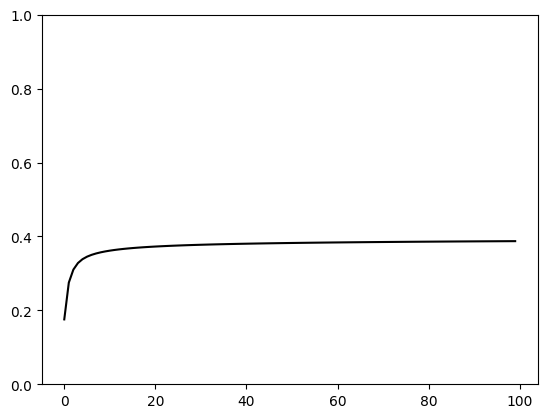

In [30]:
prior = lcpfn.sample_from_prior(np.random)
curve, _ = prior()
plt.plot(curve, "black")
plt.ylim(0, 1)

## Extrapolate the learning curve with a cutoff of 10%

In [20]:
print(curve)

[0.41764839 0.52130498 0.55571251 0.5729553  0.58333795 0.59028288
 0.59525629 0.5989923  0.60189971 0.60422455 0.60612389 0.6077028
 0.60903429 0.61017068 0.6111505  0.61200271 0.61274956 0.61340839
 0.61399294 0.61451425 0.61498125 0.61540128 0.61578044 0.61612379
 0.61643561 0.61671953 0.61697865 0.61721562 0.61743274 0.617632
 0.61781513 0.61798367 0.61813895 0.61828216 0.61841434 0.61853643
 0.61864927 0.61875359 0.61885008 0.61893933 0.61902189 0.61909825
 0.61916886 0.61923413 0.61929443 0.61935009 0.61940144 0.61944874
 0.61949226 0.61953225 0.61956892 0.61960247 0.6196331  0.61966098
 0.61968627 0.61970912 0.61972966 0.61974804 0.61976436 0.61977875
 0.61979131 0.61980213 0.6198113  0.61981892 0.61982507 0.61982981
 0.61983322 0.61983537 0.61983631 0.61983612 0.61983483 0.61983252
 0.61982922 0.61982498 0.61981984 0.61981386 0.61980706 0.61979948
 0.61979117 0.61978215 0.61977245 0.61976211 0.61975116 0.61973961
 0.61972751 0.61971486 0.6197017  0.61968804 0.61967392 0.6196593

In [31]:
# construct 

x = torch.arange(1, 101).unsqueeze(1)
y = torch.from_numpy(curve).float().unsqueeze(1)
cutoff = 10

In [50]:
def predict_single_sequence(model, input_sequence):
    model.eval()  # Ensure the model is in eval mode
    with torch.no_grad():  # No gradients needed
        # Assuming input_sequence is already a PyTorch tensor with the right shape and dtype
        prediction = model(input_sequence).to(device)
        # Convert the prediction back to a Python number for easy interpretation
        predicted_value = prediction.item()
    return predicted_value

# Example usage
input_data = y[:15].unsqueeze(0).to(device)  # Example input sequence

input_tensor = torch.tensor(input_data, dtype=torch.float).unsqueeze(0).unsqueeze(-1).to(device)



predictions = torch.tensor(predict_single_sequence(model, input_data)).to(device).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
print(f"Predicted Value: {predictions}")
print(input_data.shape)
print(predictions.shape)
result_tensor = torch.cat((input_data, torch.tensor(predictions)), dim=1)
print(result_tensor)


predictions = torch.tensor(predict_single_sequence(model, result_tensor)).to(device).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
print(f"Predicted Value: {predictions}")
print(input_data.shape)
print(predictions.shape)
result_tensor = torch.cat((result_tensor, torch.tensor(predictions)), dim=1)
print(result_tensor)

Predicted Value: tensor([[[0.6085]]], device='cuda:0')
torch.Size([1, 15, 1])
torch.Size([1, 1, 1])
tensor([[[0.1755],
         [0.2751],
         [0.3103],
         [0.3280],
         [0.3384],
         [0.3453],
         [0.3502],
         [0.3540],
         [0.3570],
         [0.3595],
         [0.3616],
         [0.3633],
         [0.3649],
         [0.3663],
         [0.3675],
         [0.6085]]], device='cuda:0')
Predicted Value: tensor([[[0.6085]]], device='cuda:0')
torch.Size([1, 15, 1])
torch.Size([1, 1, 1])
tensor([[[0.1755],
         [0.2751],
         [0.3103],
         [0.3280],
         [0.3384],
         [0.3453],
         [0.3502],
         [0.3540],
         [0.3570],
         [0.3595],
         [0.3616],
         [0.3633],
         [0.3649],
         [0.3663],
         [0.3675],
         [0.6085],
         [0.6085]]], device='cuda:0')


C:\Users\remil\AppData\Local\Temp\ipykernel_6280\1803032512.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_data, dtype=torch.float).unsqueeze(0).unsqueeze(-1).to(device)
C:\Users\remil\AppData\Local\Temp\ipykernel_6280\1803032512.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result_tensor = torch.cat((input_data, torch.tensor(predictions)), dim=1)
C:\Users\remil\AppData\Local\Temp\ipykernel_6280\1803032512.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result_tensor = torch.cat((result_

In [15]:
predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

AttributeError: 'TransformerModel' object has no attribute 'predict_quantiles'

IndexError: too many indices for tensor of dimension 1

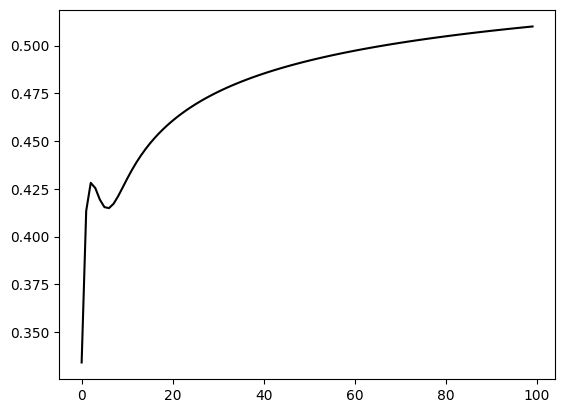

In [19]:
# plot data
plt.plot(curve, "black", label="target")

# plot extrapolation
plt.plot(x[cutoff:], predictions[:, 1], "blue", label="Extrapolation by PFN")
plt.fill_between(
        x[cutoff:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
)

# plot cutoff
plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
plt.ylim(0, 1)
plt.legend(loc="lower right")